# Getting Started on the Fraud Prediction Challenge

A brief overview of the challenge
Bank A is a private owned bank which has been faced with a lot of issues from their customers who were being defrauded. 
You've been tasked as a data scientist to build a machine learning model that can accurately flag if a given transaction
is fraudulent or not. Your solution will help bank A's from losing its customers.

### Importing the neccessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### User defiined function

In [2]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, unique numbers, datatypes etc.
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total', 'Percent','Nunique', 'Dtype'])
    display(quality_df)

### Reading Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
print('no of rows: ',train.shape[0],'\nno of columns: ',train.shape[1])

no of rows:  10493 
no of columns:  14


Let's see what our data looks like

In [4]:
train.head(3)

,transaction time,current bank amount,last bank amount,time taken (seconds),most recent bank amount,account type,marital_status,age,occupation,credit card type,account source verification,transaction source method,account destination verification,fradulent
0,2016-10-05T01:44:58,43671,1151263,2299,348764,saving,married,46,musician,master,True,False,True,0
1,2015-01-14T15:05:07,7442,1062843,4553,225114,current,single,64,accounting,master,True,False,False,0
2,2016-10-28T13:44:58,40102,48042,1493,420486,current,married,41,farmer,master,True,True,True,0


### Check the event rate
The number of fraudulent and non-fradulent samples present in the training set

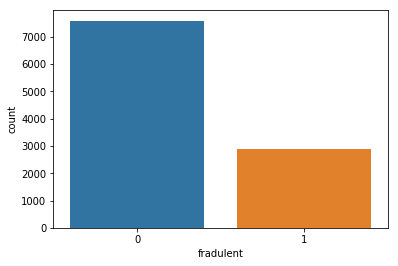

In [5]:
sns.countplot(train['fradulent'])

In [6]:
train.fradulent.value_counts()

0    7590
1    2903
Name: fradulent, dtype: int64

We have an imbalanced dataset to deal with here, though not extremely imbalanced, only 27% of the training sample are fraudulent transactions..I'll go ahead
to train with it but you could check up how to handle class imbalance here
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18


### Check for duplicate rows

In [7]:
duplicateRows = train[train.duplicated()]
print('Number of duplicate rows: ',duplicateRows.shape[0])

Number of duplicate rows:  0


### Display the Attributes/Features

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10493 entries, 0 to 10492
Data columns (total 14 columns):
transaction time                    10493 non-null object
current bank amount                 10493 non-null int64
last bank amount                    10493 non-null int64
time taken (seconds)                10493 non-null int64
most recent bank amount             10493 non-null int64
account type                        10493 non-null object
marital_status                      10493 non-null object
age                                 10493 non-null int64
occupation                          10493 non-null object
credit card type                    10493 non-null object
account source verification         10493 non-null bool
transaction source method           10493 non-null bool
account destination verification    10493 non-null bool
fradulent                           10493 non-null int64
dtypes: bool(3), int64(6), object(5)
memory usage: 932.6+ KB


It turns out we have rows with the object dtype which are categorical features, I'll also treat ones with bool dtype as a categorical feature too (i.e True or false)

### Quick descriptive statistics

In [9]:
# This gives summary statistics on all numerical features present in the dataset
train.describe()

,current bank amount,last bank amount,time taken (seconds),most recent bank amount,age,fradulent
count,10493.000000,1.049300e+04,10493.000000,10493.000000,10493.000000,10493.000000
mean,50001.984656,7.492752e+05,2508.627657,250768.667588,54.649004,0.276661
std,28681.350627,4.336081e+05,1432.820357,144145.272817,14.350928,0.447369
min,1.000000,8.000000e+00,4.000000,34.000000,30.000000,0.000000
25%,25243.000000,3.787840e+05,1282.000000,126333.000000,42.000000,0.000000
50%,50093.000000,7.485950e+05,2520.000000,253174.000000,55.000000,0.000000
75%,74539.000000,1.126013e+06,3710.000000,376461.000000,67.000000,1.000000
max,99989.000000,1.499877e+06,4999.000000,499926.000000,79.000000,1.000000


### Checking Data quality (Missing values)

In [10]:
#Function displays the percentage of missing value in any dataframe
quality_report(train)

,Total,Percent,Nunique,Dtype
account destination verification,0,0.0,2,bool
account source verification,0,0.0,2,bool
account type,0,0.0,2,object
age,0,0.0,50,int64
credit card type,0,0.0,2,object
current bank amount,0,0.0,10009,int64
fradulent,0,0.0,2,int64
last bank amount,0,0.0,10453,int64
marital_status,0,0.0,3,object
most recent bank amount,0,0.0,10378,int64


We don't have to handle any missing values, It makes things easier. To check for missing values you could
also use train.isnull.sum() which gives the sum of all missing values in each column of the data

### A little exploratory data analysis  (EDA)

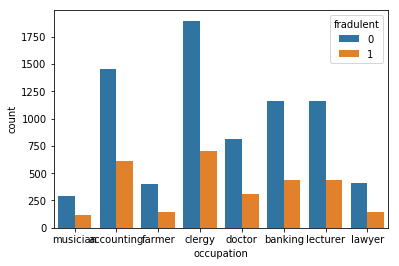

In [11]:
sns.countplot(train['occupation'], hue = train['fradulent'])

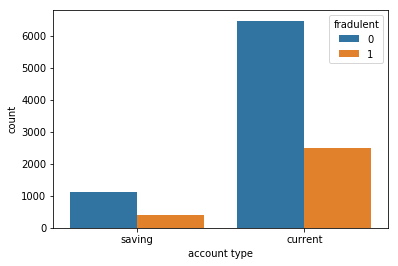

In [12]:
sns.countplot(train['account type'], hue = train['fradulent'])

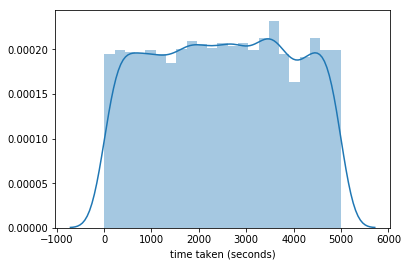

In [13]:
sns.distplot(train['time taken (seconds)'])

### Can we make inference from EDA
- Most account with fraudulent transactions belonged to Clergies, and fraudulent transactions happened with mostly current accounts.
- Distribution of time taken for transactions looks uniform,In this case,meaning there is a possibly unlimited number of     outcomes i.e transactions have almost the same probability to span any length of time.

### Preparing data for modeling

You can’t fit categorical variables into a learning algorithm in their raw form. They must be treated. One way of doing this is Dummy coding,It is a commonly used method for converting a categorical input variable into continuous variable. ‘Dummy’, as the name suggests is a duplicate variable which represents one level of a categorical variable. Presence of a level is represent by 1 and absence is represented by 0. For every level present, one dummy variable will be created. https://towardsdatascience.com/machine-learning-on-categorical-variables-3b76ffe4a7cb

In [ ]:
train = pd.get_dummies(columns = ['account type','credit card type','account source verification',
                                  'transaction source method', 'account destination verification',
                                  'occupation'], data = train)
test  = pd.get_dummies(columns = ['account type','credit card type','account source verification',
                                  'transaction source method', 'account destination verification',
                                  'occupation'], data = test)

selecting input features(columns) X and target y

In [15]:
X = train.drop(columns = ['fradulent','marital_status', 'transaction time'])
y = train['fradulent'] 

Before training our data is usually split into a training data and a local test data. We have this local testset (or subset) in order to test our model’s peformance, before predicting on the actual test data. I'll take 20% of the training data for this purpose

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

### Picking a baseline algorithm

Here is a loop to train and evaluate different models, hence we get to pick one with the best result

In [17]:
seed = 7
# prepare models
models = []
models.append(('Lr', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('Knn', KNeighborsClassifier()))
models.append(('Decision_Tree', DecisionTreeClassifier()))
models.append(('Extra_Tree', ExtraTreeClassifier()))
models.append(('RF', RandomForestClassifier())) 
models.append(('GBM', GradientBoostingClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    results.append(score)
    names.append(name)
    msg = "%s: %f " % (name, score)
    print(msg)

Lr: 0.525441 
LDA: 0.597072 
Knn: 0.490983 
Decision_Tree: 0.526723 
Extra_Tree: 0.559935 
RF: 0.598755 
GBM: 0.631461 


### Feature importance plot

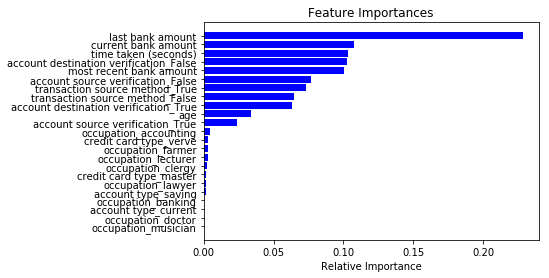

In [19]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [20]:
model = GradientBoostingClassifier(n_estimators=50)
model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.6354293515110696

GradientBoosting Classifier seem to be doing a good job. Now lets Predict on the test data and making submission

In [22]:
test_x = test.drop(columns = ['marital_status', 'transaction time'])

In [23]:
pred = model.predict_proba(test_x)[:,1]

In [24]:
df = pd.read_csv('sample sub.csv')
df['fradulent'] = pred
df[['id','fradulent']].to_csv('submit.csv', index = False)

### Suggestions.
- To improve model performance, Some features were not use for training e.g Transaction Time, 
  more features could be gotten from this e.g the hour of the day,day of week etc the transaction took place. see      https://medium.com/@swethalakshmanan14/simple-ways-to-extract-features-from-date-variable-using-python-60c33e3b0501
  
- Some features not be usefull for prediction, you could try selecting features manually,plotting feature importance will help
- Performing cross validation across different training folds is a better way of evaluating model performance, One need to sure that the model generalizes https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
- Try using more robust learning algorithms like xgboost,catboost,LightGBM etc.